In [201]:
import os
import pandas as pd
import time
import csv
import requests
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import jieba
from PIL import Image
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1.数据采集

In [2]:
def get_page(c_time,c_url):
    # 获取评论信息
    url = f'https://games.mobileapi.hupu.com/1/8.0.65/bplcommentapi/bpl/comment/list?publishTime={c_time}&order=desc&outBizNo={c_url}&outBizType=games_series&clientCode='
    response = requests.get(url=url).json()
    # 获取评论信息
    info = []
    for i in response['data']['comments']:
        commentId = i['commentKey']['commentId']
        commentUserId = i['commentUserId']
        publishTime = i['publishTime']
        commentUserName = i['commentUserName']
        commentDate = i['commentDate']
        ipLocation = i['ipLocation']
        commentContent = i['commentContent']
        score = i['score']
        info.append([commentId, commentUserId, publishTime, commentUserName, commentDate, ipLocation, commentContent, score])

    # 获取下一页的时间
    next_publishTime = response['data']['cursor']['publishTime']

    return next_publishTime, info

def save_info(name, character_info):
    # 保存数据
    csv_file_path = f"YuanShenData/{name}.csv"
    with open(csv_file_path, mode='a', newline='',encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerows(character_info)

def auto(name,c_time,c_url,num):
    # 自动化获取角色评论信息
    n = 1
    if num == 0:
        num = 5
    else:
        num = num // 10
    while n <= num:
        character_info = get_page(c_time,c_url)
        # 保存数据
        save_info(name,character_info[1])
        # 更新角色评论时间
        c_time = character_info[0]
        print(f'Successfully:{name},{10*n}')
        # 让程序休息一下
        time.sleep(random.random())
        n = n + 1

def main():
    # 主程序
    # 角色基础时间和网址
    characters = {'liulangzhe':['1709134726206','259',0],
                'zhongli':['1701483717295','213',0],
                'leidianjiangjun':['1708954459258','155',0],
                'shenlilinghua':['1709135204698','102',0],
                'fukaluosi':['1709135262877','2982',0],
                'hutao':['1709135339736','212',0],
                'paimeng':['1700402064064','210',0],
                'funingna':['1709135631618','4814',0],
                'xiaogong':['1709135674054','264',0],
                'naxida':['1709135734803','148',0]}
    for i in characters:
        character_name = i
        character_time = characters.get(i)[0]
        character_url = characters.get(i)[1]
        character_num = characters.get(i)[2]
        auto(character_name,character_time,character_url,character_num)

# main()

# 2.数据清洗

## 2.1 读取数据

In [190]:
# 读取数据
data = pd.DataFrame()
for i in os.listdir('../input/YuanShenComment/'):
    a = pd.read_csv('../input/YuanShenComment/'+i, header=None)
    a['character'] = i[:-4]
    data = pd.concat([data, a],ignore_index=True)
data.columns = ['commentId', 'commentUserId', 'publishTime', 'commentUserName',
                'commentDate', 'ipLocation', 'commentContent', 'score','character']
data = data.drop(columns=['commentId', 'commentUserId', 'publishTime'])
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52664 entries, 0 to 52663
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   commentUserName  52664 non-null  object
 1   commentDate      52664 non-null  object
 2   ipLocation       35395 non-null  object
 3   commentContent   52602 non-null  object
 4   score            52664 non-null  int64 
 5   character        52664 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.4+ MB
None


commentUserName commentDate ipLocation   commentContent  score  character
0  虎扑JR1039652545        9小时前         云南               老婆     10  fukaluosi
1             陆晓涵       12小时前         云南               喜欢     10  fukaluosi
2      poiyipoiyi       23小时前         广西  目前人物形象塑造的最完美的角色     10  fukaluosi
3            云澈本人       02-28        黑龙江          水龙水龙别哭啦     10  fukaluosi
4  虎扑JR2030318786       02-27         浙江                。     10  fukaluosi

In [191]:
# 删除评论中有缺失值得行
data = data.dropna(subset='commentContent')
# 删除未打分的行
data = data[data['score'] != 0]

# 将日期统一格式
comment_date = []
for i in data['commentDate']:
    if '小时前' in i:
        i = '2024-02-29'
    if len(i) < 9:
        i = f'2024-{i}'
    comment_date.append(i)
df_comment_date = pd.DataFrame(comment_date)
data['commentDate'] = df_comment_date

# 将评分离散化
def score_bin(data_score):
    '''
    将打分离散化
    '''
    if data_score in [4,6,8]:
        return None
    elif data_score == 2:
        return 0
    else:
        return 1
data['score'] = data['score'].apply(score_bin)

# 中文分词并去除停用词
with open('../input/stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = set(file.read().splitlines())
    
def word_cut(text):
    words = jieba.cut(text)
    filtered_words = [word for word in words if word not in stopwords]
    if filtered_words == []:
        return None
    else:
        return ' '.join(filtered_words)
    
data['commentSplit'] = data['commentContent'].apply(word_cut)
data = data.dropna(subset=['score','commentSplit']).reset_index(drop=True)
data

commentUserName commentDate ipLocation   commentContent  score  \
0      虎扑JR1039652545  2024-02-29         云南               老婆    1.0   
1                 陆晓涵  2024-02-29         云南               喜欢    1.0   
2          poiyipoiyi  2024-02-29         广西  目前人物形象塑造的最完美的角色    1.0   
3                云澈本人  2024-02-28        黑龙江          水龙水龙别哭啦    1.0   
4               Em1ys  2024-02-27         河南         伟大，无需多言！    1.0   
...               ...         ...        ...              ...    ...   
45490         金州龙爪手普尔         NaN        NaN          钟老爷永远满分    1.0   
45491         地球沉睡的夜晚         NaN        NaN            得闲饮茶！    1.0   
45492         Hothom3         NaN        NaN             固若金汤    1.0   
45493     RNG欠钱不还天理难容         NaN        NaN        安全感，璃月的神！    1.0   
45494    Murray的27号球衣         NaN        NaN        你是来找钟莉玩的吗    1.0   

       character   commentSplit  
0      fukaluosi             老婆  
1      fukaluosi             喜欢  
2      fukaluosi  人物形象 塑造 完美 角色  
3      fukaluosi       水龙 水龙 别哭  
4      fukaluosi          无需 多言  
...          ...            ...  
45490    zhongli     钟 老爷 永远 满分  
45491    zhongli          得闲 饮茶  
45492    zhongli           固若金汤  
45493    zhongli        安全感 璃 神  
45494    zhongli         找 钟莉 玩  

[45495 rows x 7 columns]

In [192]:
# 保存数据
data.to_csv('../input/genshin.csv', index=None)

# 3.探索性数据分析

[3059 2414 2314 2155 1580 1519 1505 1485 1348 1248 1069 1028  981  945
  929  912  789  672  638  619  510  493  465  406  340  294  289  198
  224]
Index(['广东', '山东', '江苏', '河南', '四川', '河北', '安徽', '浙江', '湖北', '湖南', '江西', '福建',
       '辽宁', '北京', '陕西', '广西', '重庆', '山西', '黑龙江', '上海', '云南', '吉林', '贵州', '天津',
       '内蒙古', '甘肃', '新疆', '海南', '其他'],
      dtype='object', name='ipLocation')


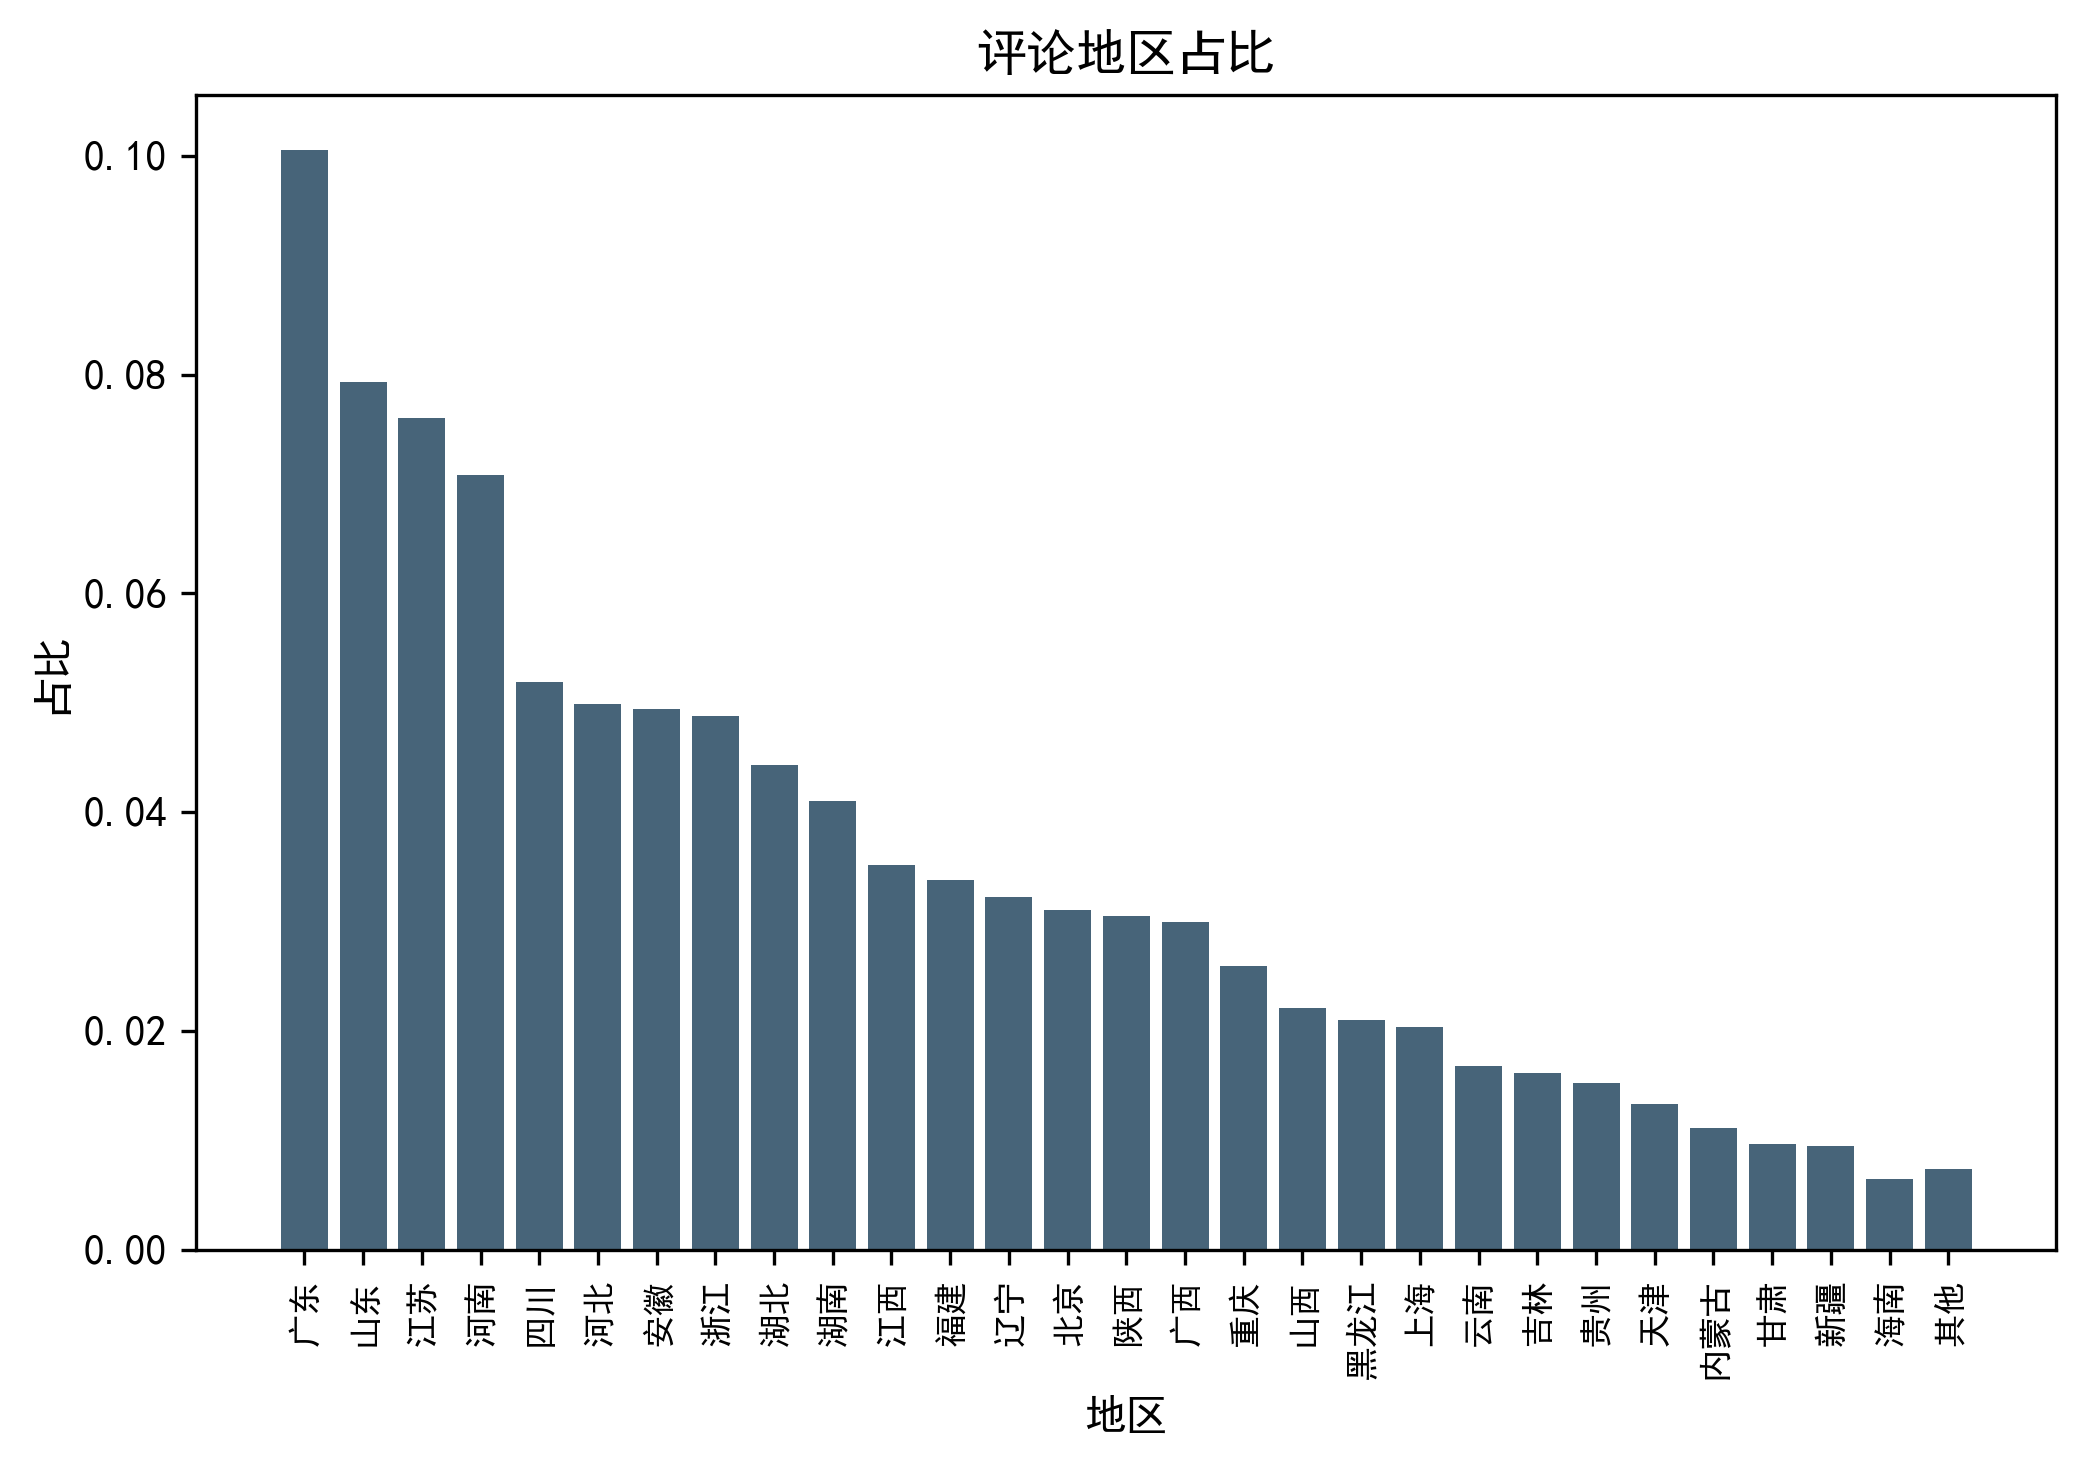

In [193]:
# 绘制条形图
ipLocation = data['ipLocation'].value_counts()
ipLocation_most = ipLocation[ipLocation.values > 100]
ipLocation_most['其他'] = int(ipLocation[ipLocation.values < 100].values.sum())
print(ipLocation_most.values)
print(ipLocation_most.index)

plt.figure(figsize=(8, 5),dpi=300)
percent = ipLocation_most.values/ipLocation_most.values.sum()
plt.bar(ipLocation_most.index, percent, color='#476479')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.xticks(rotation=90, fontsize=8)
plt.title('评论地区占比')
plt.xlabel('地区')
plt.ylabel('占比')
plt.show()

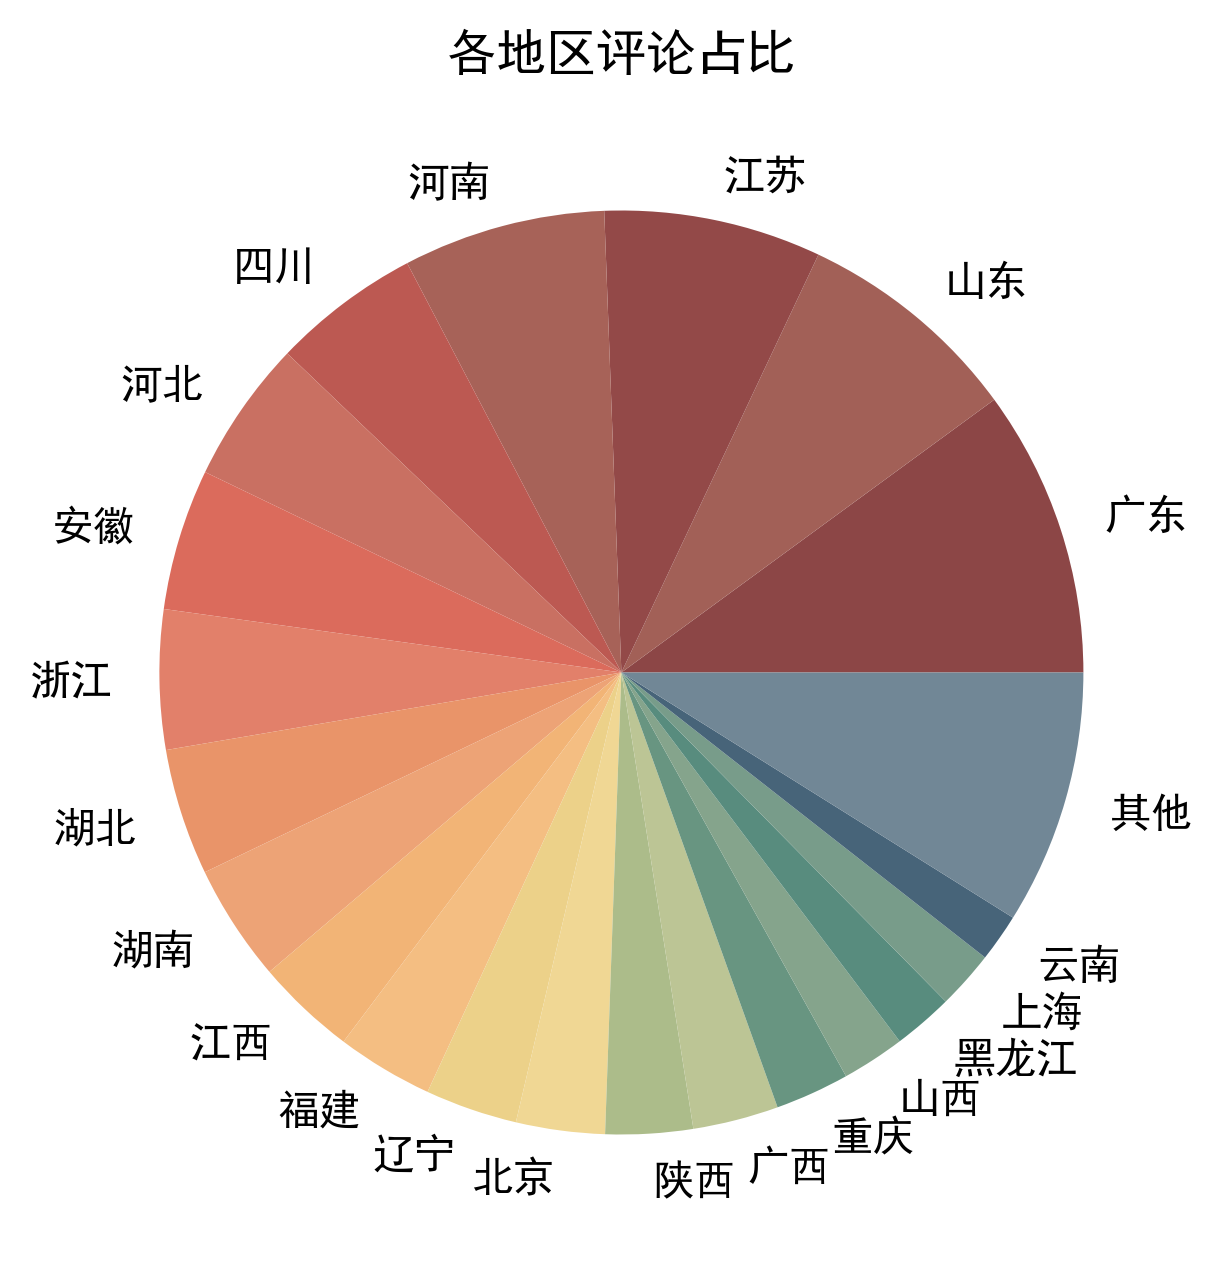

In [195]:
# 绘制饼图
ipLocation = data['ipLocation'].value_counts()
ipLocation_most = ipLocation[ipLocation.values > 500]
ipLocation_most['其他'] = int(ipLocation[ipLocation.values < 500].values.sum())
ipLocation_most

colors = ["#8c4646","#a26057","#934948","#a76258",'#bc5952','#c97062',
          '#db6b5c','#e2806a','#e99469','#eda376','#f2b476','#f4be82',
          '#ecd189','#f0d794','#acbc8a','#bcc595','#689581','#85a48c',
          '#588c7e','#789c8a','#476479','#718796','#5e598e','#8581a9']
# colors = plt.cm.plasma(range(2))
plt.figure(figsize=(15,5),dpi=300)
plt.pie(x=ipLocation_most.values,labels=ipLocation_most.index,colors=colors)
plt.title('各地区评论占比')
# plt.savefig('pie_chart.png', dpi=300)
plt.show()

In [197]:
data

commentUserName commentDate ipLocation   commentContent  score  \
0      虎扑JR1039652545  2024-02-29         云南               老婆    1.0   
1                 陆晓涵  2024-02-29         云南               喜欢    1.0   
2          poiyipoiyi  2024-02-29         广西  目前人物形象塑造的最完美的角色    1.0   
3                云澈本人  2024-02-28        黑龙江          水龙水龙别哭啦    1.0   
4               Em1ys  2024-02-27         河南         伟大，无需多言！    1.0   
...               ...         ...        ...              ...    ...   
45490         金州龙爪手普尔         NaN        NaN          钟老爷永远满分    1.0   
45491         地球沉睡的夜晚         NaN        NaN            得闲饮茶！    1.0   
45492         Hothom3         NaN        NaN             固若金汤    1.0   
45493     RNG欠钱不还天理难容         NaN        NaN        安全感，璃月的神！    1.0   
45494    Murray的27号球衣         NaN        NaN        你是来找钟莉玩的吗    1.0   

       character   commentSplit  
0      fukaluosi             老婆  
1      fukaluosi             喜欢  
2      fukaluosi  人物形象 塑造 完美 角色  
3      fukaluosi       水龙 水龙 别哭  
4      fukaluosi          无需 多言  
...          ...            ...  
45490    zhongli     钟 老爷 永远 满分  
45491    zhongli          得闲 饮茶  
45492    zhongli           固若金汤  
45493    zhongli        安全感 璃 神  
45494    zhongli         找 钟莉 玩  

[45495 rows x 7 columns]

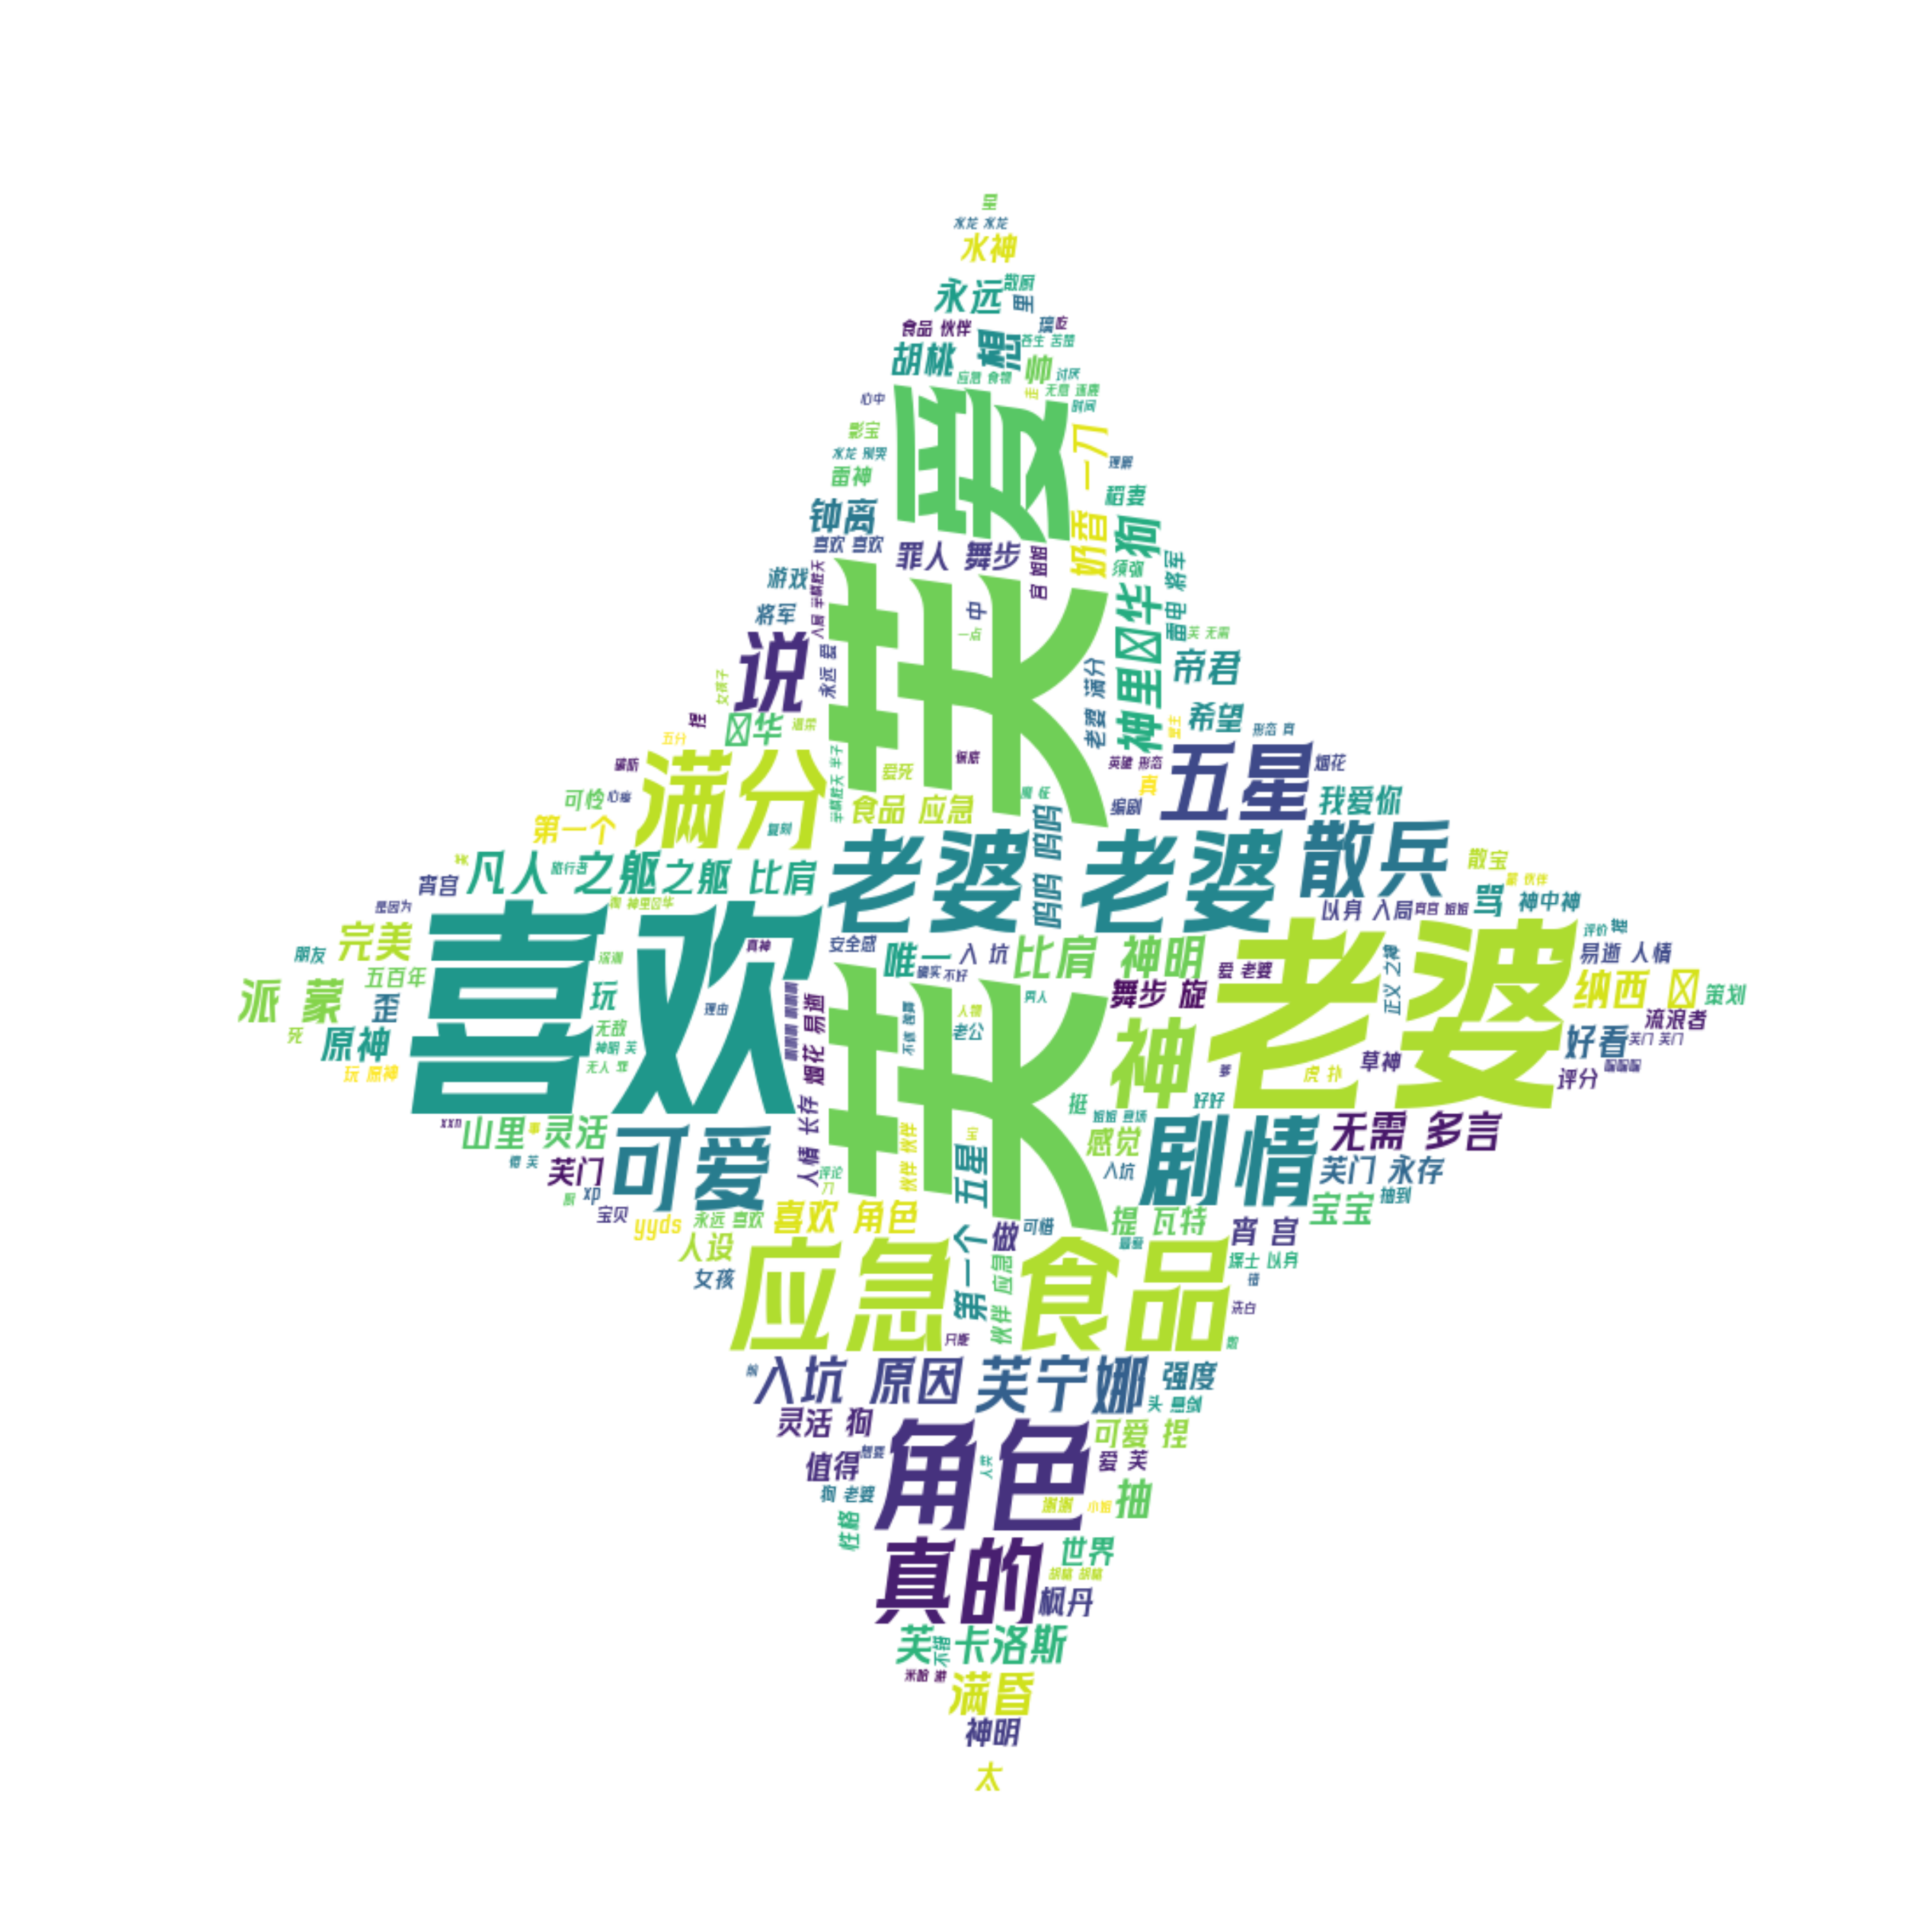

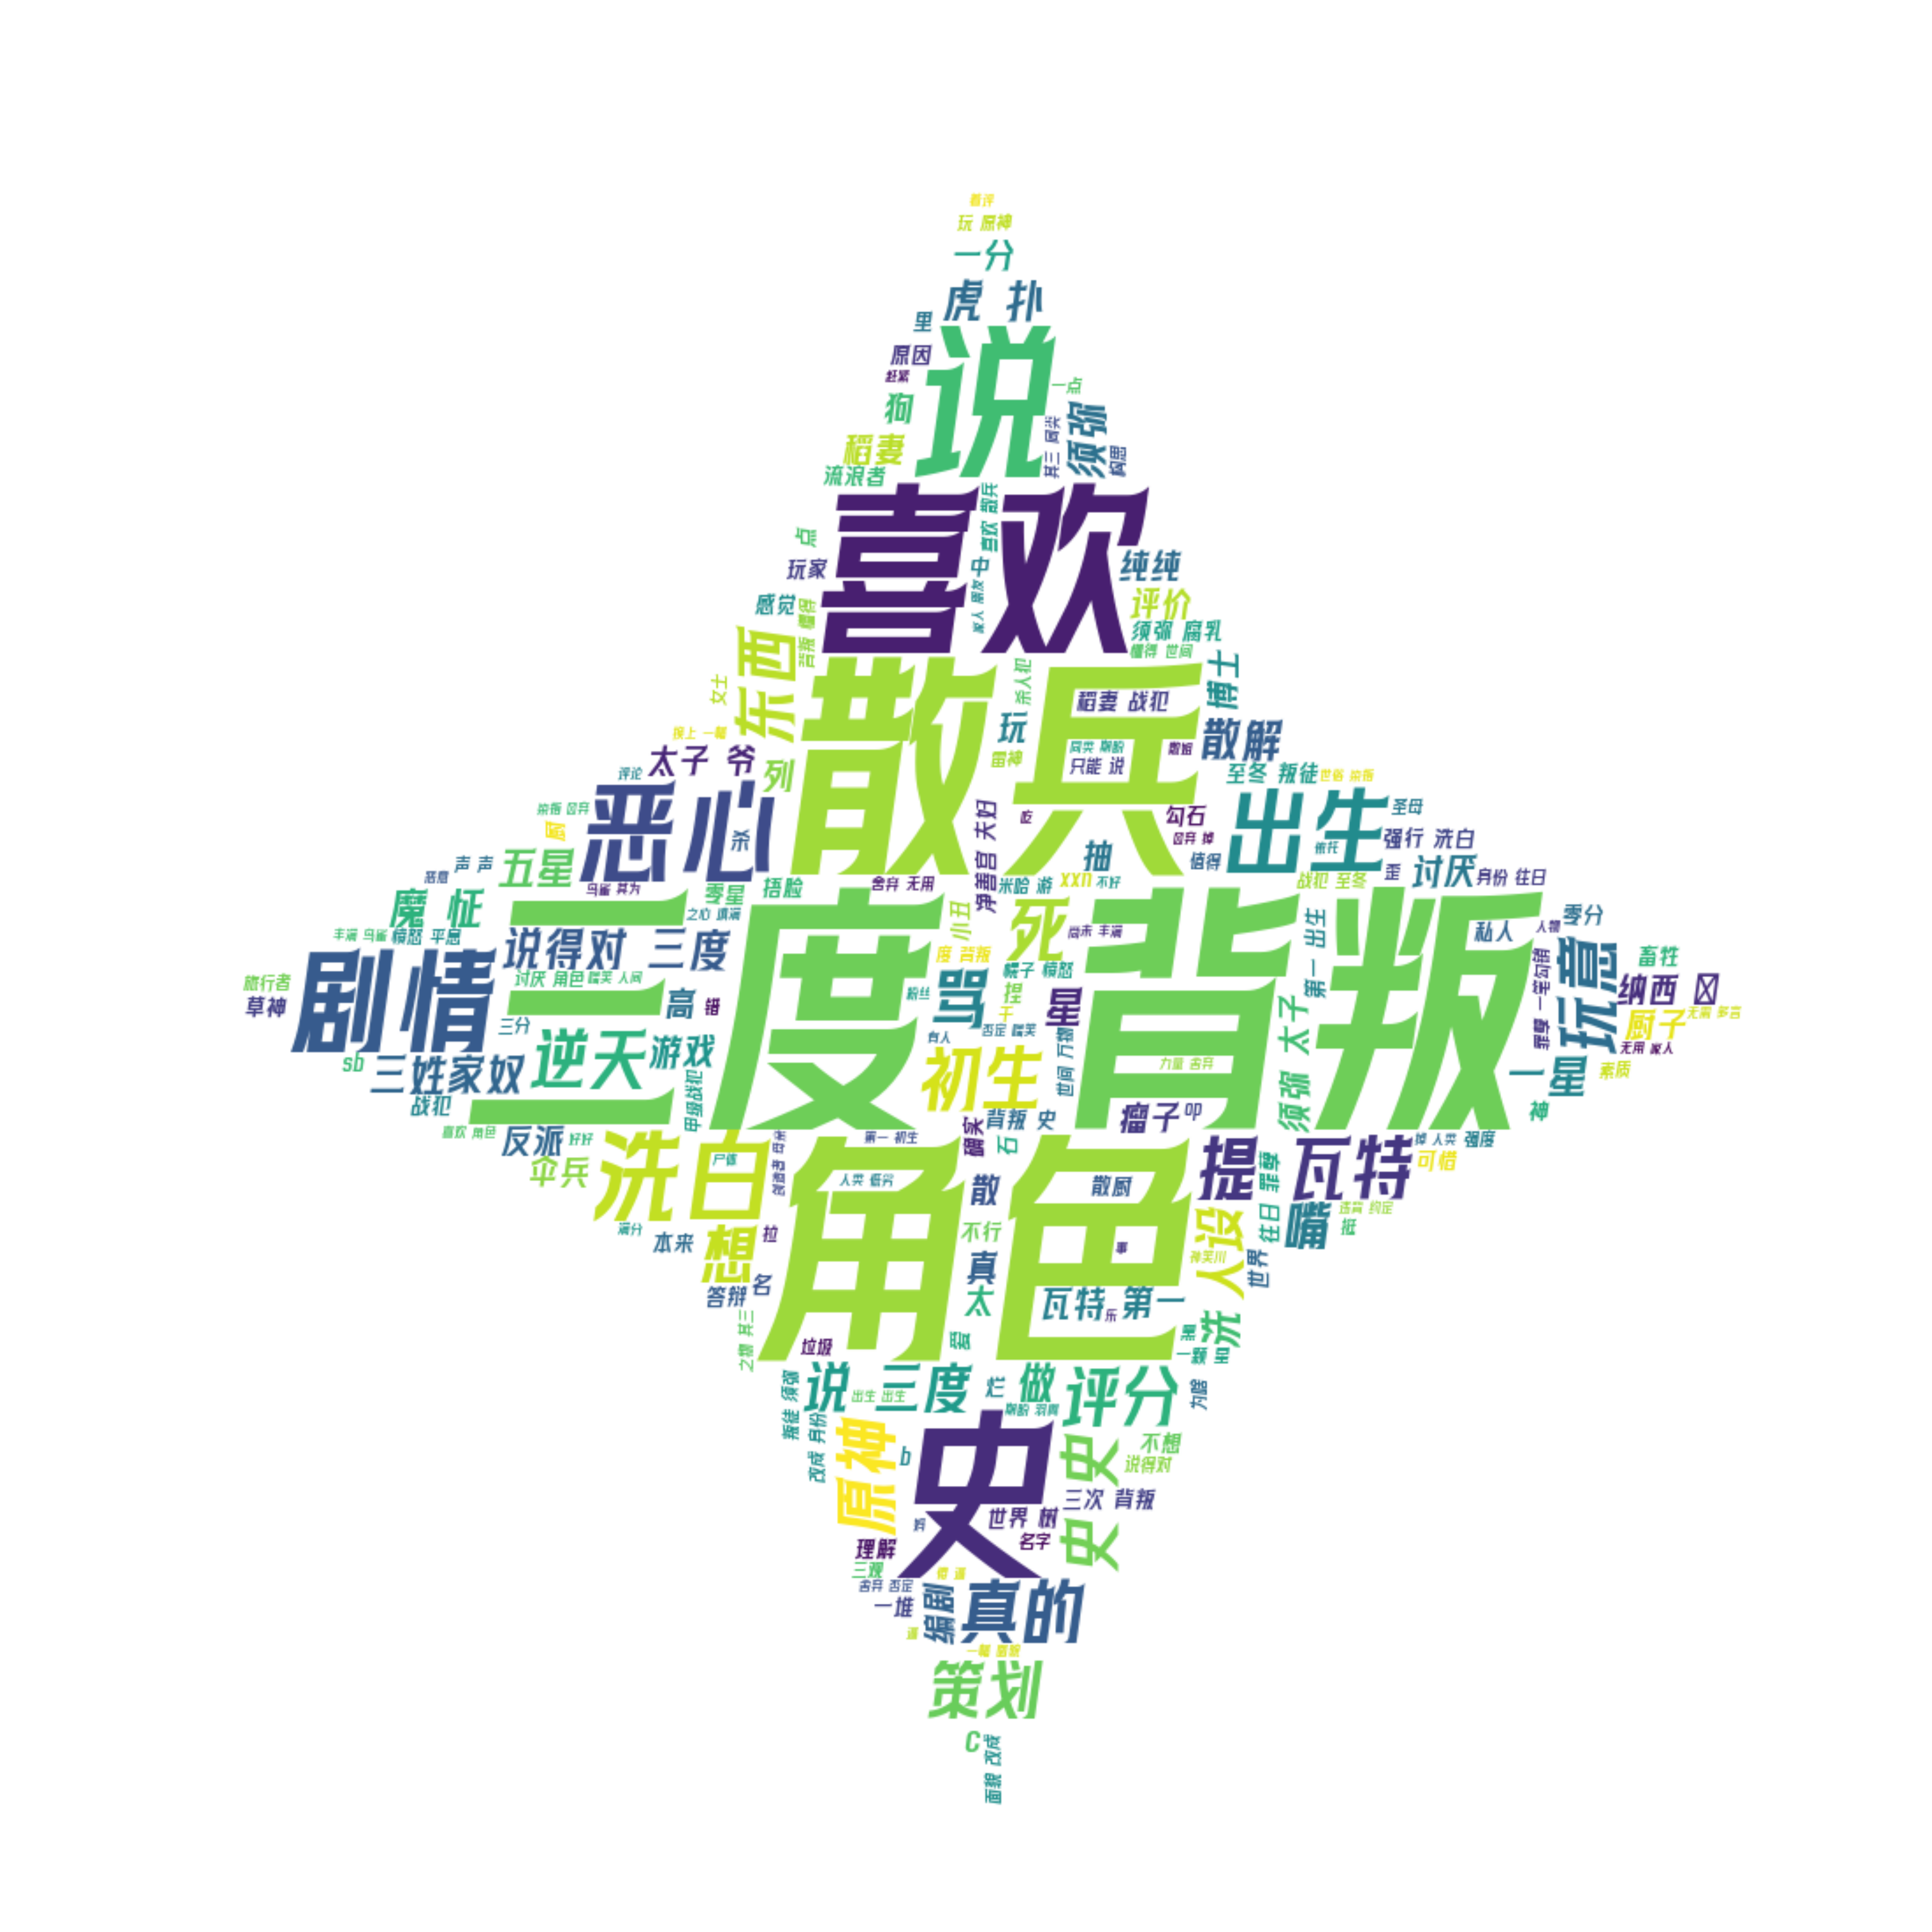

In [ ]:
# 绘制正面评论情感词云图
pos_comment = []
for i in data[data['score'] == 1]['commentSplit']:
    pos_comment += i.split()

# 将评论数据转换为字符串格式
text = ' '.join(pos_comment)
# 生成词云图
mask = np.array(Image.open("../image/yuanshi.png"))
wordcloud = WordCloud(font_path="../input/font.ttf", background_color='white', mode="RGBA", mask=mask)
wordcloud.generate(text)

plt.figure(figsize=(15, 15),dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 绘制负面评论情感词云图
pos_comment = []
for i in data[data['score'] == 0]['commentSplit']:
    pos_comment += i.split()

# 将评论数据转换为字符串格式
text = ' '.join(pos_comment)
# 生成词云图
mask = np.array(Image.open("../image/yuanshi.png"))
wordcloud = WordCloud(font_path="../input/font.ttf", background_color='white', mode="RGBA", mask=mask)
wordcloud.generate(text)

plt.figure(figsize=(15, 15),dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()